# Loan Status Prediction

## Introduction


In this project, I performe data analysis and predictive modelling on Lending Club's loan data set for the year 2015 in order to understand how different set of features help to indentify customer loan status. This can potentially  

## Lending Club Data

Lending Club is one of the America's largest lending companies that allows borrowers
to apply and obtain personal loans, auto refinancing, business loans, and elective medical procedures.
Additionally, they make some of their data publically available.  


![title](https://getbackonfeet.com/wp-content/uploads/2018/10/000-2-1.png)

## ETL Pipline

1. **Data Cleaning**:

    * Drop irrelevant features
    * Clean mixed type features
    * ....

2. **Exploratory Analysis**


3. **Machine Learning** 
    * Feature Normalization
    * Train Test Split
    * Cross Validation
    * ML Prediction
    


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

#plotly
from plotly.plotly import iplot
import plotly.graph_objs as go

from src.utility import *
from src.plotting import *
from src.ml_models import *

%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")

## Loan Data

In [2]:
keep_cols = ["loan_status","loan_amnt", "term","int_rate","installment","grade",
             "sub_grade","purpose","emp_length","home_ownership","annual_inc",
             "verification_status","issue_d","dti","earliest_cr_line","open_acc",
             "revol_bal","revol_util","total_acc"]

df_orig = pd.read_csv("data/loan.csv", usecols=keep_cols,skipfooter=1,skiprows=1)#,low_memory=False)

In [3]:
df = df_orig
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 19 columns):
loan_amnt              9997 non-null int64
term                   9997 non-null object
int_rate               9997 non-null object
installment            9997 non-null float64
grade                  9997 non-null object
sub_grade              9997 non-null object
emp_length             9448 non-null object
home_ownership         9997 non-null object
annual_inc             9997 non-null float64
verification_status    9997 non-null object
issue_d                9997 non-null object
loan_status            9997 non-null object
purpose                9997 non-null object
dti                    9997 non-null float64
earliest_cr_line       9997 non-null object
open_acc               9997 non-null int64
revol_bal              9997 non-null int64
revol_util             9992 non-null object
total_acc              9997 non-null int64
dtypes: float64(3), int64(4), object(12)
memory usage: 1.4

In [4]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,open_acc,revol_bal,revol_util,total_acc
0,24700,36 months,11.99%,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,16.06,Dec-1999,22,21470,19.2%,38
1,17925,60 months,17.27%,448.09,D,D3,10+ years,OWN,39000.0,Source Verified,Dec-2015,Current,debt_consolidation,27.78,Sep-2002,10,19614,76%,21
2,9000,36 months,8.49%,284.07,B,B1,8 years,MORTGAGE,47000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,8.43,Nov-2000,12,9747,26.7%,22
3,11550,60 months,16.59%,284.51,D,D2,5 years,RENT,38000.0,Not Verified,Dec-2015,Charged Off,credit_card,21.07,Jan-2011,9,7179,39.7%,12
4,12000,60 months,9.80%,253.79,B,B3,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,23.84,Nov-2003,18,9786,13.4%,37


There were overall 145 features and most of them were irrelevant. So we keep most important features for further processing that reduces memory usage and improves performance.

### Fix Target Feature

In [5]:
# simplify target feature
df.loan_status.value_counts()

Fully Paid            6958
Charged Off           1672
Current               1244
Late (31-120 days)      86
Late (16-30 days)       19
In Grace Period         17
Default                  1
Name: loan_status, dtype: int64

Target feature 'loan_status' has 7 factors. We will reduce it to two 'Good' and 'Bad' loans.

In [6]:
good_loans = ['Fully Paid', 'Current']

def LoanCondition(status):
    if status in good_loans:
        return 'Good Loan'
    else:
        return 'Bad Loan'
tmp = df['loan_status'].apply(LoanCondition)
df.loan_status = tmp

### Clean Features

Some features have mixed type such as number mixed with string.

* Remove '%' from 'int_rate', 'revol_util' 
* Replace all 'n/a' with np.nan
* Extract numeric part of employment length
* Save name of the loan issued month
* Get credita agae from issue data and earliest credit line
* Again drop some unnecessary columns

In [7]:
df = CleanData(df)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,issue_month,cred_age
0,24700,36,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Good Loan,small_business,16.06,22,21470,19.2,38,Dec,16.0
1,17925,60,17.27,448.09,D,D3,10,OWN,39000.0,Source Verified,Good Loan,debt_consolidation,27.78,10,19614,76.0,21,Dec,13.0
2,9000,36,8.49,284.07,B,B1,8,MORTGAGE,47000.0,Not Verified,Good Loan,debt_consolidation,8.43,12,9747,26.7,22,Dec,15.0
3,11550,60,16.59,284.51,D,D2,5,RENT,38000.0,Not Verified,Bad Loan,credit_card,21.07,9,7179,39.7,12,Dec,5.0
4,12000,60,9.80,253.79,B,B3,10,MORTGAGE,65000.0,Not Verified,Good Loan,debt_consolidation,23.84,18,9786,13.4,37,Dec,12.0


In [8]:
#statistics of numeric features
df.describe().iloc[[1,2,3,7],:].round(1)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,cred_age
mean,15116.9,43.1,12.3,441.5,5.7,78890.6,19.5,12.4,17582.2,51.0,26.0,16.8
std,8720.0,10.9,4.3,251.0,3.8,64417.8,13.1,5.9,22524.2,24.2,12.3,7.6
min,1000.0,36.0,5.3,30.5,0.0,1770.0,0.0,1.0,0.0,0.0,4.0,3.0
max,35000.0,60.0,29.0,1354.7,10.0,3964280.0,999.0,55.0,566420.0,134.3,105.0,59.0


### Loan Status & Amount

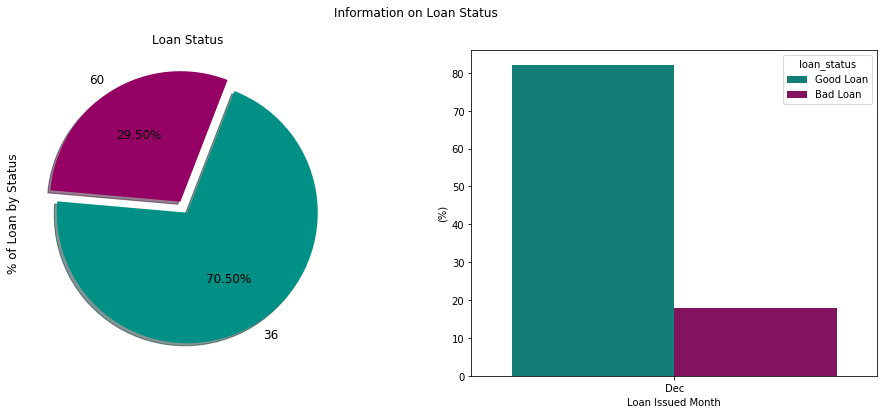

In [9]:
plotLoanStat1(df,colors = ColorList([11,12]))

* Based on fraction of 'Good' and 'Bad' loans, we don't have data imbalance problem.
* Percentage of issued loans seem to reduce as year ending!

In [10]:
df.purpose.value_counts()

debt_consolidation    5723
credit_card           2469
home_improvement       562
other                  552
major_purchase         214
medical                108
car                    103
small_business         102
vacation                65
moving                  52
house                   43
renewable_energy         4
Name: purpose, dtype: int64

In [11]:
ave_good_loan_by_purpose = df[df.loan_status == 'Good Loan'].groupby('purpose').loan_amnt.mean().astype(int)
ave_bad_loan_by_purpose = df[df.loan_status == 'Bad Loan'].groupby('purpose').loan_amnt.mean().astype(int)

good_bars = go.Bar(
    x = list(ave_good_loan_by_purpose.index),
    y = list(ave_good_loan_by_purpose.values),
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


bad_bars = go.Bar(
    x = list(ave_bad_loan_by_purpose.index),
    y = list(ave_bad_loan_by_purpose.values),
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219,64,82,0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

data = [good_bars, bad_bars]

layout = go.Layout(
    title='Average Amount of Loan given for Different Purposes Classified by Loan Status',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='Average Loan Amount',
    ),
    paper_bgcolor='rgba(250,200,200,0.3)',
    plot_bgcolor='rgba(250,200,200,0.3)',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig)


### Let's  look at how features are correlated

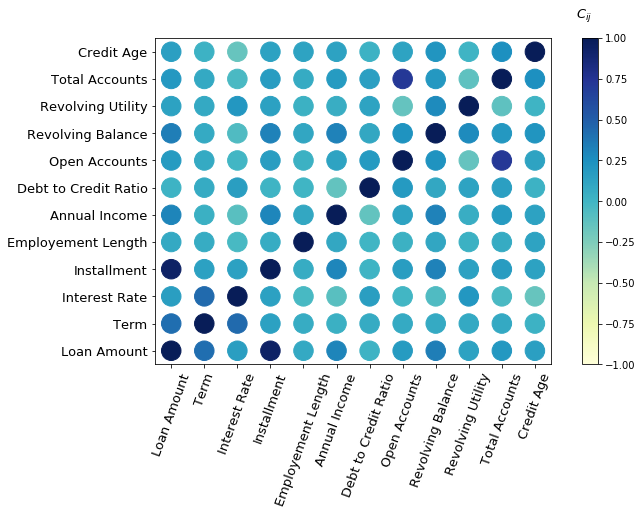

In [12]:
cor = df.corr()
corr_names = ['Loan Amount', 'Term', 'Interest Rate', 'Installment', 'Employement Length',
              'Annual Income', 'Debt to Credit Ratio', 'Open Accounts', 'Revolving Balance',
              'Revolving Utility', 'Total Accounts','Credit Age']

cmap = "YlGnBu"
plt.figure(figsize=(9,6))
CPlot(corr_mat = cor.values, axis_labs = corr_names,cmap = cmap,
      pad = 0.05,rad = 380, xlab = '',ylab = '',fs = 13,
      xtick_lab_rot = 70)

'loan_amnt' and 'installment' are highly correlated

## Interest Rate

Sort 'grade' and 'sub_grade' in alphabetic order and check how interest rate varies across different grades.

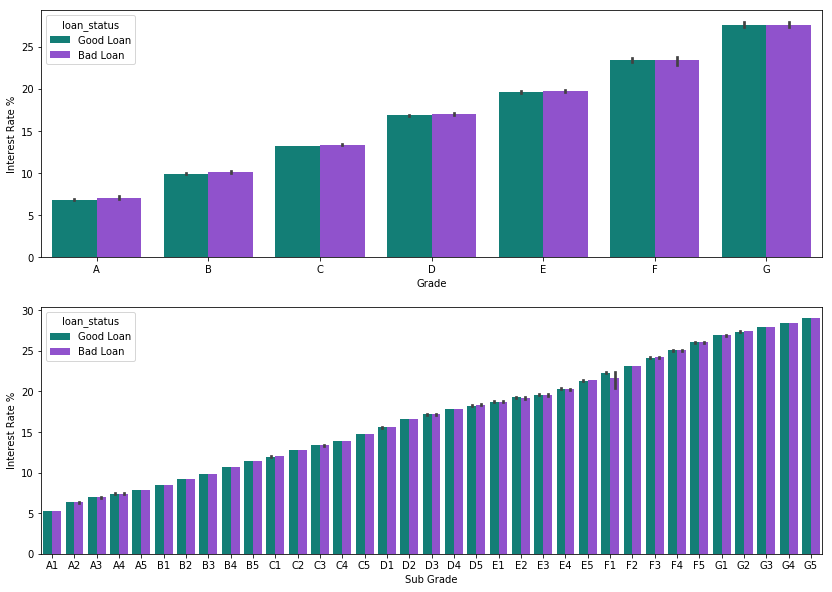

In [13]:
colors = ColorList([11,1])
plotLoanStats2(df,colors)

sdfsdfffffffffffff

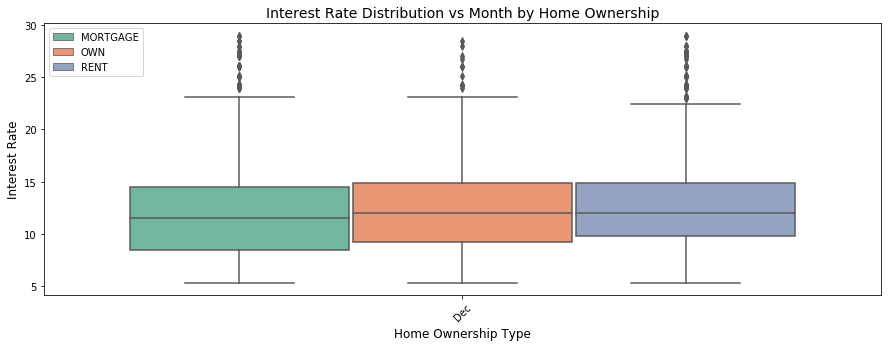

In [12]:
plotLoanStat3(df)

### Bla Bla

In [106]:
ave_good_loan_by_grade = df[df.loan_status == 'Good Loan'].groupby('grade',axis=0).loan_amnt.mean().astype(int)
ave_bad_loan_by_grade = df[df.loan_status == 'Bad Loan'].groupby('grade',axis=0).loan_amnt.mean().astype(int)

#prepare data for plotly
data = [
    go.Scatterpolar(mode='lines+markers',
        r = list(ave_good_loan_by_grade.values),
        theta = list(ave_good_loan_by_grade.index),
        fill = 'toself',
        name = 'Good Loans',
        line = dict(color = "#63AF63"),
        marker = dict(color = "#B3FFB3",symbol = "square",size = 11),
        subplot = "polar1"),

    go.Scatterpolar(
        mode='lines+markers',
        r = list(ave_bad_loan_by_grade.values),
        theta = list(ave_bad_loan_by_grade.index),
        fill = 'toself', name = 'Bad Loans',
        line = dict(color = "#C31414"),
        marker = dict(color = "#FF5050",symbol = "square",size = 11),
        subplot = "polar2")
]

#define layout
layout = go.Layout(
    title="Average Good and Bad Loans by Grade",
    showlegend = False,
    paper_bgcolor = "rgb(255, 248, 243)",
    polar1 = dict(
        domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 12
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 12
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)